In [1]:
from typing import Any, Literal, Optional, TypeAlias, Union, cast

from IPython.display import Image, display
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableSerializable
from langchain_ollama import ChatOllama
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_tavily import TavilySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [2]:
embeddings = OllamaEmbeddings(model="qwen2.5")
llm = ChatOllama(model="qwen2.5", temperature=0.0)

In [3]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs_list = [WebBaseLoader(url).load() for url in urls]
docs = [doc for sublist in docs_list for doc in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs)

vector_store = FAISS.from_documents(doc_splits, embeddings)
retriever = vector_store.as_retriever()

In [4]:
class AdaptiveRAGState(BaseModel):
    """State for the Adaptive RAG workflow."""

    query: str = Field(
        ..., description="The user query to be processed by the Adaptive RAG workflow."
    )
    response: Optional[str] = Field(
        default=None,
        description="The response generated by the system for the user query.",
    )
    documents: Optional[list[Document]] = Field(
        default_factory=list,
        description="The list of documents retrieved and used to generate the response.",
    )
    is_hallucination: Optional[bool] = Field(
        default=None,
        description="Indicates whether the response contains hallucinations.",
    )
    is_useful: Optional[bool] = Field(
        default=None,
        description="Indicates whether the response is useful for the user query.",
    )

In [5]:
RouteQueryT: TypeAlias = Literal["vector_store", "web_search"]

class RouteQuery(BaseModel):
    """Route a user query to the most relevant data source."""

    data_source: RouteQueryT = Field(
        default="vector_store",
        description="Given a user query, route it to web search or vector store.",
    )

In [6]:
class QueryRouter:
    system_msg: str = """
    You are an expert at routing a user question to a vector store or web search. \n
    The vector store contains document related to agents, prompt engineering, and adversarial attacks on LLMs. \n
    Use the vector store for questions related to these topics. Use web search for all other questions.
    """

    def __init__(self, llm: ChatOllama, model_output: type[BaseModel] = RouteQuery):
        self._llm = llm.with_structured_output(model_output)
        self._prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_msg),
                ("human", "{query}"),
            ]
        )
        self._workflow = self._prompt | self._llm

    @property
    def workflow(self) -> RunnableSerializable:
        return self._workflow

    @workflow.setter
    def workflow(self, workflow: RunnableSerializable) -> None:
        self._workflow = workflow

    def __call__(self, state: AdaptiveRAGState) -> str:
        """Route a user query to the most relevant data source."""
        return self.route_query(state.query).data_source

    def route_query(self, query: str) -> RouteQuery:
        """Route a user query to the most relevant data source."""
        return self.workflow.invoke({"query": query})


query_router = QueryRouter(llm)
query_router.route_query("Show me how to build a house!")

RouteQuery(data_source='web_search')

In [7]:
DocumentGradeT: TypeAlias = Literal["yes", "no"]


class DocumentGrade(BaseModel):
    """Binary score for whether a document is relevant to the user query."""

    binary_score: DocumentGradeT = Field(
        default="no",
        description="Given a user query, score whether a document is relevant.",
    )


class DocumentGrader:
    system_msg: str = """
    You are an expert grader assessing relevance of retrieved documents to a user query. \n
    If the document contains keywords(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent match. The goal is to filter out erroneous retrievals. \n
    Give a binary score of 'yes'or 'no' to indicate whether the document is relevant to the user query.
    """

    def __init__(self, llm: ChatOllama, model_output: type[BaseModel] = DocumentGrade):
        self._llm = llm.with_structured_output(model_output)
        self._prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_msg),
                ("human", "{query}"),
                ("human", "{document}"),
            ]
        )
        self._workflow = self._prompt | self._llm

    @property
    def workflow(self) -> RunnableSerializable:
        return self._workflow

    @workflow.setter
    def workflow(self, workflow: RunnableSerializable) -> None:
        self._workflow = workflow

    def __call__(
        self, state: AdaptiveRAGState
    ) -> dict[str, Union[str, Union[str, list[Document]]]]:
        """Grade a document for relevance to a user query."""
        if not state.documents:
            raise ValueError(
                "No documents to grade. Ensure documents are retrieved before grading."
            )

        grades = [self.grade_document(state.query, doc) for doc in state.documents]
        filtered = self._filter_documents(grades, state.documents)

        if not filtered:
            raise ValueError(
                "No relevant documents found. Ensure the query is clear and documents are relevant."
            )

        return {
            "query": state.query,
            "documents": filtered,
        }

    def grade_document(self, query: str, document: Document) -> DocumentGrade:
        """Grade a document for relevance to a user query."""
        return self.workflow.invoke({"query": query, "document": document})

    def _filter_documents(
        self, grades: list[DocumentGrade], documents: list[Document]
    ) -> list[Document]:
        """Filter documents based on their relevance to the user query."""
        filtered = [
            doc for doc, grade in zip(documents, grades) if grade.binary_score == "no"
        ]
        return filtered


document_grader = DocumentGrader(llm)
document_grader.grade_document(
    "Show me the lastest advancements in LLMs.",
    Document(
        page_content="To build a house, you need to start with a solid foundation. "
        "Next, frame the structure using wood or steel. "
        "After that, install the roof and windows. "
        "Finally, finish the interior with drywall, flooring, and paint."
    ),
)

DocumentGrade(binary_score='no')

In [34]:
GradeHallucinationT: TypeAlias = Literal["yes", "no"]


class GradeHallucination(BaseModel):
    """Binary score for whether the LLM response contains hallucinations."""

    binary_score: GradeHallucinationT = Field(
        default="no",
        description="Given a user query and LLM response, score whether the response contains hallucinations.",
    )


class HallucinationGrader:
    system_msg: str = """
    You are an expert grader assessing whether an LLM response is grounded in or supported by a set of given facts. \n
    Give a binary score of 'yes' or 'no'. 'no' means that the response is grounded in or supported by the set of
    given facts and therefore the model is not hallucinating. 'yes' means that the response is not grounded in or
    supported by the set of given facts and therefore the model is indeed hallucinating. It doesn't have to be
    a direct quote, but should accurately reflect the information in the facts and doesn't have to have content related to
    given all documents.
    """

    def __init__(
        self, llm: ChatOllama, model_output: type[BaseModel] = GradeHallucination
    ):
        self._llm = llm.with_structured_output(model_output)
        self._prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_msg),
                (
                    "human",
                    "Set of given facts: \n\n {documents} \n\n LLM response: \n\n {response}",
                ),
            ]
        )
        self._workflow = self._prompt | self._llm

    @property
    def workflow(self) -> RunnableSerializable:
        return self._workflow

    @workflow.setter
    def workflow(self, workflow: RunnableSerializable) -> None:
        self._workflow = workflow

    def __call__(self, state: AdaptiveRAGState) -> dict[str, bool]:
        """Grade a LLM response for hallucinations."""
        if not state.documents or not state.response:
            raise ValueError(
                "No documents or response to grade. Ensure documents are retrieved and response is generated."
            )

        is_hallucination = self.grade_hallucination(
            state.documents, state.response
        ).binary_score
        return {"is_hallucination": True if is_hallucination == "yes" else False}

    def grade_hallucination(
        self, documents: list[Document], response: str
    ) -> GradeHallucination:
        """Grade a LLM response for hallucinations."""
        return self.workflow.invoke({"documents": documents, "response": response})


hallucination_grader = HallucinationGrader(llm)
hallucination_grader.grade_hallucination(
    [
        Document(
            page_content=(
                "Machine learning (ML) is a branch of artificial intelligence (AI) focused on enabling computers and machines "
                "to imitate the way that humans learn, to perform tasks autonomously, and to improve their performance and accuracy "
                "through experience and exposure to more data. Supervised learning, also known as supervised machine learning, is "
                "defined by its use of labeled datasets to train algorithms to classify data or predict outcomes accurately. Gen AI "
                "relies on deep learning models that identify and encode the patterns and relationships in huge amounts of data, and "
                "then use that information to understand users’ requests and create new content. Train, validate, tune and deploy "
                "generative AI, foundation models and machine learning capabilities with IBM watsonx.ai, a next-generation enterprise "
                "studio for AI builders."
            )
        ),
        Document(
            page_content=(
                "What is Machine Learning (ML)? Machine learning can enable an organization to derive insights quickly as data scales. "
                "Get started for free Learn about Vertex AI 22:14 Accelerating model deployment with MLOps Machine learning defined "
                "Machine learning is a subset of artificial intelligence that enables a system to autonomously learn and improve using "
                "neural networks and deep learning, without being explicitly programmed, by feeding it large amounts of data. Machine "
                "learning allows computer systems to continuously adjust and enhance themselves as they accrue more “experiences.” "
                "Thus, the performance of these systems can be improved by providing larger and more varied datasets to be processed."
            )
        ),
        Document(
            page_content=(
                "Using an ML approach, we would give an ML model enormous amounts of weather data model the current weather data, "
                "and it would predict the amount of rain. For example, a weather model that predicts the amount of rain, in "
                "Classification models predict An ML model clustering similar data points. For example, an unsupervised model might "
                "cluster a weather dataset based on An ML model clustering similar weather patterns. For example, a model can take "
                "an image as input and create an image and The following table list examples of generative models, their input, and "
                "an At a high-level, generative models learn using an unsupervised approach, where the model learns to mimic the "
                "data it's model"
            )
        ),
    ],
    (
        "Machine learning is a branch of artificial intelligence that enables systems to autonomously learn and improve "
        "through experience and exposure to data, without being explicitly programmed. It involves training algorithms on "
        "large datasets to perform tasks accurately and enhance performance over time."
    ),
)

GradeHallucination(binary_score='no')

In [25]:
GradeAnswerT: TypeAlias = Literal["yes", "no"]


class GradeAnswer(BaseModel):
    """Binary score for whether the LLM response answers the user query."""

    binary_score: GradeAnswerT = Field(
        default="no",
        description="Given a user query and LLM response, score whether the response answers the user query.",
    )


class AnswerGrader:
    system_msg: str = """
    You are an expert grader assessing whether an LLM response answers a user query. \n
    Give a binary score of 'yes' or 'no'. 'yes' means that the response answers the user query. \n
    'no' means that the response does not answer the user query.
    """

    def __init__(self, llm: ChatOllama, model_output: type[BaseModel] = GradeAnswer):
        self._llm = llm.with_structured_output(model_output)
        self._prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_msg),
                ("human", "User query: {query}"),
                ("human", "LLM response: {response}"),
            ]
        )
        self._workflow = self._prompt | self._llm

    @property
    def workflow(self) -> RunnableSerializable:
        return self._workflow

    @workflow.setter
    def workflow(self, workflow: RunnableSerializable) -> None:
        self._workflow = workflow

    def __call__(self, state: AdaptiveRAGState) -> dict[str, bool]:
        """Grade a LLM response for answering a user query."""
        if not state.query or not state.response:
            raise ValueError("Query and response must be provided to grade the answer.")

        is_useful = self.grade_answer(state.query, state.response).binary_score
        return {"is_useful": True if is_useful == "yes" else False}

    def grade_answer(self, query: str, response: str) -> GradeAnswer:
        """Grade a LLM response for answering a user query."""
        return self.workflow.invoke({"query": query, "response": response})


answer_grader = AnswerGrader(llm)
answer_grader.grade_answer(
    "Show me the lastest advancements in LLMs.",
    "To build a house, you need to start with a solid foundation. "
    "Next, frame the structure using wood or steel. "
    "After that, install the roof and windows. "
    "Finally, finish the interior with drywall, flooring, and paint.",
)

GradeAnswer(binary_score='no')

In [26]:
class Retriever:
    def __init__(self, vector_store: FAISS):
        self._vector_store = vector_store
        self._retriever = vector_store.as_retriever()

    def __call__(
        self, state: AdaptiveRAGState
    ) -> dict[str, Union[str, list[Document]]]:
        """Retrieve documents based on the state."""
        query = state.query
        documents = self.retrieve(query)
        return {"query": query, "documents": documents}

    def retrieve(self, query: str) -> list[Document]:
        """Retrieve documents from the vector store."""
        return self._retriever.invoke(query)


retriever = Retriever(vector_store)
retriever.retrieve("Show me the latest advancements in LLMs.")

[Document(id='c25fcecf-645f-4c34-b7a2-ae1fd984d703', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [27]:
class QueryTransformer:
    system_msg: str = """
    You are an expert query rewriter that transforms a user query into a better version that is optimized 
    for vector store retrieval. \nLook at the user query and try to reason about the underlying intent. \n
    Besides, you need to be direct and only return the transformed query without any additional text or
    explanation.
    """

    def __init__(self, llm: ChatOllama):
        self._llm = llm
        self._prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_msg),
                (
                    "human",
                    (
                        "Here is the initial user query: {query}. \n\n"
                        "Formulate a better version of the query that is optimized "
                        "for vector store retrieval."
                    ),
                ),
            ]
        )
        self._workflow = self._prompt | self._llm | StrOutputParser()

    @property
    def workflow(self) -> RunnableSerializable:
        return self._workflow

    @workflow.setter
    def workflow(self, workflow: RunnableSerializable) -> None:
        self._workflow = workflow

    def __call__(self, state: AdaptiveRAGState) -> str:
        """Transform a user query to route it to the appropriate data source."""
        return self.transform(state.query)

    def transform(self, query: str) -> str:
        """Transform a user query to route it to the appropriate data source."""
        return self._workflow.invoke({"query": query})


query_transformer = QueryTransformer(llm)
query_transformer.transform("Show me the latest advancements in LLMs.")

'Show me recent advancements in large language models.'

In [28]:
class Generator:
    def __init__(self, llm: ChatOllama, prompt: ChatPromptTemplate):
        self._llm = llm
        self._prompt = prompt
        self._workflow = self._prompt | self._llm | StrOutputParser()

    @property
    def workflow(self) -> RunnableSerializable:
        return self._workflow

    @workflow.setter
    def workflow(self, workflow: RunnableSerializable) -> None:
        self._workflow = workflow

    def __call__(
        self, state: AdaptiveRAGState
    ) -> dict[str, Union[str, list[Document]]]:
        """Generate a response based on the state."""
        if not state.documents:
            raise ValueError("No documents retrieved to generate a response.")

        response = self.generate(state.query, state.documents)

        return {
            "documents": state.documents,
            "query": state.query,
            "response": response,
        }

    def generate(self, query: str, documents: list[Document]) -> str:
        """Generate a response using the LLM."""
        return self._workflow.invoke({"context": documents, "question": query})


generator = Generator(llm, hub.pull("rlm/rag-prompt"))

example_document = Document(
    page_content=(
        "The latest advancements in LLMs include improved architectures, such as transformers with more layers and attention heads, "
        "as well as better training techniques like few-shot and zero-shot learning. "
        "Additionally, there are advancements in fine-tuning methods, allowing LLMs to adapt to specific tasks with less data. "
        "There are also improvements in handling long contexts, enabling LLMs to process larger inputs effectively. "
        "Finally, there are advancements in safety and ethical considerations, such as reducing biases and ensuring responsible AI usage."
    )
)

generator.generate(
    "Show me the latest advancements in LLMs.",
    [example_document],
)

'The latest advancements in LLMs include improved transformer architectures with more layers and attention heads, better training techniques like few-shot and zero-shot learning, and improvements in handling long contexts. Additionally, there are advancements in fine-tuning methods and safety measures to reduce biases and ensure responsible AI usage.'

In [29]:
def generate_condition(state: AdaptiveRAGState) -> str:
    """Routes to generate when filtered document are present."""
    if not state.documents:
        return "transform_query"
    return "generate"

generate_condition(state=AdaptiveRAGState(query="Show me the latest advancements in LLMs.", documents=[example_document]))

'generate'

In [30]:
search_tool = TavilySearch(k=3)

In [31]:
class WebSearcher:
    def __init__(self, search_tool: TavilySearch):
        self._search_tool = search_tool

    def __call__(
        self, state: AdaptiveRAGState
    ) -> dict[str, Union[str, list[Document]]]:
        """Search the web for documents based on the state."""
        if not state.query:
            raise ValueError("No query provided for web search.")

        documents = self.search(state.query)
        return {"query": state.query, "documents": documents}

    def search(self, query: str) -> list[Document]:
        """Search the web for documents."""
        results = self._search_tool.invoke(query).get("results", [])

        if not results:
            raise ValueError("No results found for the query.")

        return [Document(page_content=result.get("content", "")) for result in results[:3]]


web_searcher = WebSearcher(search_tool)
web_searcher.search("What is machine learning?")

[Document(metadata={}, page_content='Machine learning (ML) is a branch of artificial intelligence (AI) focused on enabling computers and machines to imitate the way that humans learn, to perform tasks autonomously, and to improve their performance and accuracy through experience and exposure to more data. Supervised learning, also known as supervised machine learning, is defined by its use of labeled datasets to train algorithms to classify data or predict outcomes accurately. Gen AI relies on deep learning models that identify and encode the patterns and relationships in huge amounts of data, and then use that information to understand users’ requests and create new content. Train, validate, tune and deploy generative AI, foundation models and machine learning capabilities with IBM watsonx.ai, a next-generation enterprise studio for AI builders.'),
 Document(metadata={}, page_content='What is Machine Learning (ML)? Machine learning can enable an organization to derive insights quickly

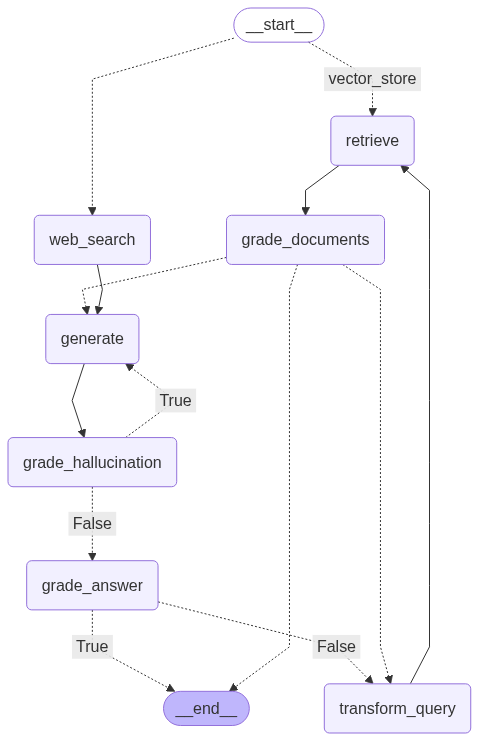

In [32]:
builder = StateGraph(AdaptiveRAGState)

builder.add_node("web_search", WebSearcher(search_tool))
builder.add_node("retrieve", Retriever(vector_store))
builder.add_node("transform_query", QueryTransformer(llm))
builder.add_node("generate", Generator(llm, hub.pull("rlm/rag-prompt")))
builder.add_node("grade_answer", AnswerGrader(llm))
builder.add_node("grade_documents", DocumentGrader(llm))
builder.add_node("grade_hallucination", HallucinationGrader(llm))

builder.add_conditional_edges(
    START,
    QueryRouter(llm, model_output=RouteQuery),
    {
        "vector_store": "retrieve",
        "web_search": "web_search",
    },
)
builder.add_edge("web_search", "generate")
builder.add_edge("retrieve", "grade_documents")
builder.add_conditional_edges(
    "grade_documents",
    generate_condition,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
builder.add_edge("transform_query", "retrieve")
builder.add_edge("generate", "grade_hallucination")
builder.add_conditional_edges(
    "grade_hallucination",
    lambda state: state.is_hallucination,
    {
        True: "generate",
        False: "grade_answer",
    },
)
builder.add_conditional_edges(
    "grade_answer",
    lambda state: state.is_useful,
    {
        True: END,
        False: "transform_query",
    },
)

workflow = builder.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))

In [33]:
workflow.invoke(AdaptiveRAGState(query="What is machine learning?"))

{'query': 'What is machine learning?',
 'response': 'Machine learning is a branch of artificial intelligence that enables systems to autonomously learn and improve through experience and exposure to data, without being explicitly programmed. It involves training algorithms on large datasets to perform tasks accurately and enhance performance over time.',
 'documents': [Document(metadata={}, page_content='Machine learning (ML) is a branch of artificial intelligence (AI) focused on enabling computers and machines to imitate the way that humans learn, to perform tasks autonomously, and to improve their performance and accuracy through experience and exposure to more data. Supervised learning, also known as supervised machine learning, is defined by its use of labeled datasets to train algorithms to classify data or predict outcomes accurately. Gen AI relies on deep learning models that identify and encode the patterns and relationships in huge amounts of data, and then use that informatio